# WMAZE MODEL GLM2


# ROI mask specs:
### Hippocampus (FS labels: hippocampus [17, 53])
### Putamen (FS labels: putamen [12, 51])
### Medial PFC (FS labels: rostral anterior cingulate [1026, 2026] & caudal anterior cingulate [1002, 2002])
### Dorsal caudate (hand-drawn)

In [1]:
from os.path import join
from glob import glob
from scipy import stats
from scipy.stats import pearsonr
from pylab import *
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")
sns.set_palette('muted')

subs = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']
proj_dir = '/home/data/madlab/Mattfeld_WMAZE' 
masks = []
copes = []
for sub in subs:
    mask_glob = glob(proj_dir + '/derivatives/roi_masks/hamm/anat_masks/_subject_id_' + sub + '/_anatmask_xfm*/*')
    masks.append(sorted(mask_glob))
    copes_glob = glob(proj_dir + '/Hamm_CellReports/GLM2/lvl2/' + sub + '/fixedfx/cope_*')
    copes.append(sorted(copes_glob))
for i, sub in enumerate(subs):
    print(sub, len(copes[i]))

WMAZE_001 22
WMAZE_002 22
WMAZE_004 22
WMAZE_005 22
WMAZE_006 22
WMAZE_007 22
WMAZE_008 22
WMAZE_009 22
WMAZE_010 22
WMAZE_012 22
WMAZE_017 22
WMAZE_018 22
WMAZE_019 22
WMAZE_020 22
WMAZE_021 22
WMAZE_022 22
WMAZE_023 22
WMAZE_024 22
WMAZE_026 22
WMAZE_027 22


## Double-check the array indexing for masks and copes

In [16]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(masks[0]):
    print(i, masks[0][i].split('/')[-1][:-14]) 

0 lh-all_mPFC
1 lh-dlPFC
2 lh-dmPFC
3 lh-hippocampus
4 lh-mPFC_fs-3reg
5 lh-mPFC_fs
6 lh-mPFC_lausanne
7 lh-motor
8 lh-parsT
9 lh_caudate_anat_mask
10 lh_insula
11 lh_vocc
12 rh_caudate_anat_mask
13 rh-all_mPFC
14 rh-dlPFC
15 rh-dmPFC
16 rh-hippocampus
17 rh-mPFC_fs-3reg
18 rh-mPFC_fs
19 rh-mPFC_lausanne
20 rh-motor
21 rh-parsT
22 rh_insula
23 rh_vocc
24 lh-putamen
25 lh_dlpfc
26 lh_dlpfc
27 rh-putamen


In [24]:
for i, curr_cope in enumerate(copes[0]):
    print(i, copes[0][i].split('/')[-1][5:-7]) 

0 AllVsBase
1 allCond_minus_allFixed
2 allCorr_minus_allIncorr
3 allFixed_minus_allCond
4 allIncorr_minus_allCorr
5 all_BL
6 all_cond
7 all_corr
8 all_fixed
9 all_incorr
10 condCorr_minus_condIncorr
11 condCorr_minus_fixedCorr
12 condIncorr_minus_condCorr
13 condIncorr_minus_fixedIncorr
14 cond_corr
15 cond_incorr
16 fixedCorr_minus_condCorr
17 fixedCorr_minus_fixedIncorr
18 fixedIncorr_minus_condIncorr
19 fixedIncorr_minus_fixedCorr
20 fixed_corr
21 fixed_incorr


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [25]:
all_data = {'subjid':[],
            'lhhp_fixed_corr':[], 'rhhp_fixed_corr':[], 
            'lhhp_fixed_incorr':[], 'rhhp_fixed_incorr':[],
            'lhhp_cond_corr':[], 'rhhp_cond_corr':[], 
            'lhhp_cond_incorr':[], 'rhhp_cond_incorr':[],
            'lhcaud_fixed_corr':[], 'rhcaud_fixed_corr':[], 
            'lhcaud_fixed_incorr':[], 'rhcaud_fixed_incorr':[],
            'lhcaud_cond_corr':[], 'rhcaud_cond_corr':[], 
            'lhcaud_cond_incorr':[], 'rhcaud_cond_incorr':[],
            'lhput_fixed_corr':[], 'rhput_fixed_corr':[], 
            'lhput_fixed_incorr':[], 'rhput_fixed_incorr':[],
            'lhput_cond_corr':[], 'rhput_cond_corr':[], 
            'lhput_cond_incorr':[], 'rhput_cond_incorr':[],
            'lhmpfc_fixed_corr':[], 'rhmpfc_fixed_corr':[], 
            'lhmpfc_fixed_incorr':[], 'rhmpfc_fixed_incorr':[],
            'lhmpfc_cond_corr':[], 'rhmpfc_cond_corr':[], 
            'lhmpfc_cond_incorr':[], 'rhmpfc_cond_incorr':[]}

for i in range(len(subs)):
    all_data['subjid'].append(subs[i])
    #ROI masks
    lh_hp_img = nb.load(mask_filenames[i][3])
    rh_hp_img = nb.load(mask_filenames[i][16])
    lh_mpfc_img = nb.load(mask_filenames[i][5])
    rh_mpfc_img = nb.load(mask_filenames[i][18])
    lh_caud_img = nb.load(mask_filenames[i][9])
    rh_caud_img = nb.load(mask_filenames[i][12])
    lh_put_img = nb.load(mask_filenames[i][24])
    rh_put_img = nb.load(mask_filenames[i][27])   
    #copes
    fixed_corr_img = nb.load(cope_files[i][20])
    fixed_incorr_img = nb.load(cope_files[i][21])
    cond_corr_img = nb.load(cope_files[i][14])
    cond_incorr_img = nb.load(cope_files[i][15]) 
    
    region = ['hp', 'mpfc', 'caud', 'put']
    learn_type = ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']   
    for r in region:
        for l in learn_type:
            lh_data = eval('{0}_img.get_fdata()[lh_{1}_img.get_fdata() > 0.]'.format(l,r))
            all_data['lh{0}_{1}'.format(r,l)].append(np.mean(lh_data)) 
            rh_data = eval('{0}_img.get_fdata()[rh_{1}_img.get_fdata() > 0.]'.format(l,r))
            all_data['rh{0}_{1}'.format(r,l)].append(np.mean(rh_data))
    
all_data_df = pd.DataFrame(all_data)

In [27]:
region = ['hp', 'mpfc', 'caud', 'put']
learn_type = ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']
for r in region:
    for l in learn_type:
        all_data_df['{0}_{1}'.format(r,l)] = (all_data_df['lh{0}_{1}'.format(r,l)] 
                                              + all_data_df['rh{0}_{1}'.format(r,l)])/2.

### Region-specific dataframes for producing plots

In [28]:
hp_plot = {}
mpfc_plot = {}
caud_plot = {}
put_plot = {}

subjid = pd.Series(all_data['subjid']) #assign Ss id as row identifier
for i in ['hp', 'mpfc', 'caud', 'put']:
    exec('{0}_plot["subjid"] = all_data_df["subjid"]'.format(i))
    exec('{0}_plot["fixed_corr"] = all_data_df["{0}_fixed_corr"]'.format(i))
    exec('{0}_plot["fixed_incorr"] = all_data_df["{0}_fixed_incorr"]'.format(i))
    exec('{0}_plot["cond_corr"] = all_data_df["{0}_cond_corr"]'.format(i))
    exec('{0}_plot["cond_incorr"] = all_data_df["{0}_cond_incorr"]'.format(i))
    exec('{0}_plot_df = pd.DataFrame.from_dict({0}_plot).set_index(subjid)'.format(i))

# Hippocampus

In [29]:
hp_plot_df

,subjid,fixed_corr,fixed_incorr,cond_corr,cond_incorr
WMAZE_001,WMAZE_001,1.091574,-0.480921,0.821142,-2.813515
WMAZE_002,WMAZE_002,-3.579686,-1.896500,-4.856936,-6.447909
WMAZE_004,WMAZE_004,0.842492,0.437192,0.227703,-0.591698
WMAZE_005,WMAZE_005,-0.609333,0.474605,-1.350032,-3.042690
WMAZE_006,WMAZE_006,-1.351821,-1.999584,-1.687969,-2.849562
WMAZE_007,WMAZE_007,2.892881,0.576164,1.064930,-0.387237
WMAZE_008,WMAZE_008,-1.849475,-2.067368,-2.570878,-3.576272
WMAZE_009,WMAZE_009,-0.032932,-2.833291,-0.878177,-0.987913
WMAZE_010,WMAZE_010,-2.228013,-5.680521,-4.621060,-6.804630
WMAZE_012,WMAZE_012,-2.050016,-2.305429,-2.269563,-1.910705


In [30]:
hp_anova = {'subjid':[], 'trial':[], 'activation':[]} #reorganizing data for Repeated Measures ANOVA

for i in range(len(subs)):
    for k in ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']: #trial type
        hp_anova['subjid'].append(subs[i])
        hp_anova['trial'].append(k)
        hp_anova['activation'].append(hp_plot_df['{0}'.format(k)][i])
df_hp_anova = pd.DataFrame(hp_anova)

In [31]:
df_hp_anova

,subjid,trial,activation
0,WMAZE_001,fixed_corr,1.091574
1,WMAZE_001,fixed_incorr,-0.480921
2,WMAZE_001,cond_corr,0.821142
3,WMAZE_001,cond_incorr,-2.813515
4,WMAZE_002,fixed_corr,-3.579686
...,...,...,...
75,WMAZE_026,cond_incorr,-7.683352
76,WMAZE_027,fixed_corr,-1.814029
77,WMAZE_027,fixed_incorr,-2.372738
78,WMAZE_027,cond_corr,-2.911773


Descriptives
Mean / STD fixed_corr:  -1.1853275883323213 / 1.9364910634211223
Shapiros fixed_corr:  0.9603140950202942

Mean / STD fixed_incorr:  -2.01949018850684 / 2.3333568695483144
Shapiros fixed_incorr:  0.5716717839241028

Mean / STD cond_corr:  -1.8487893560009223 / 2.0921288069483044
Shapiros cond_corr:  0.29368096590042114

Mean / STD cond_incorr:  -3.54961405995243 / 2.023376501521266
Shapiros cond_incorr:  0.12468361854553223

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
trial 17.5845 3.0000 57.0000 0.0000



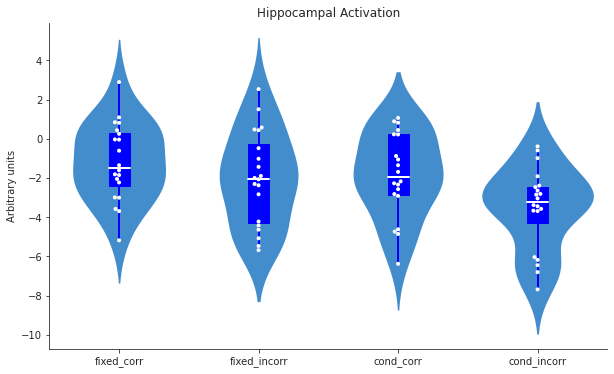

In [33]:
from statsmodels.stats.anova import AnovaRM
print('Descriptives')
for key in ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']:
    print('Mean / STD {0}: '.format(key), np.mean(hp_plot['{0}'.format(key)]), "/", np.std(hp_plot['{0}'.format(key)]))  
    if stats.shapiro(hp_plot['{0}'.format(key)])[1] > 0.049:
        print("Shapiros {0}: ".format(key), stats.shapiro(hp_plot['{0}'.format(key)])[1])
    else:
        print("Shapiros {0}: ".format(key), stats.shapiro(hp_plot['{0}'.format(key)])[1], "**")
    print("")    
print(AnovaRM(data=df_hp_anova, depvar='activation', subject='subjid', within=['trial']).fit()) 
    
N = 4
conditions = ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']
allsubjs = [hp_plot['fixed_corr'], hp_plot['fixed_incorr'], hp_plot['cond_corr'], hp_plot['cond_incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(10,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#278fea', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,showcaps=False, 
           boxprops=dict(color='blue', facecolor='blue'),
           whiskerprops=dict(color='blue', linewidth=2, linestyle="-"),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(-0.2,0.8)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampal Activation")
#plt.savefig("/home/arenf001/figs/GLM2_hpc.png", dpi=1000)
plt.show() 

### Hippocampus - Fixed vs. Conditional

HPC FIXED Mean / STD / Shapiros:  -1.6024088884195802 / 1.9951198956179348 / 0.9631114602088928
HPC COND Mean / STD / Shapiros:  -2.699201707976676 / 1.964889685086998 / 0.9428017735481262

HPC Fixed vs. Conditional
Ttest_relResult(statistic=4.266670955544377, pvalue=0.00041686656860923294) **
Cohen's d =  0.7635236678744833


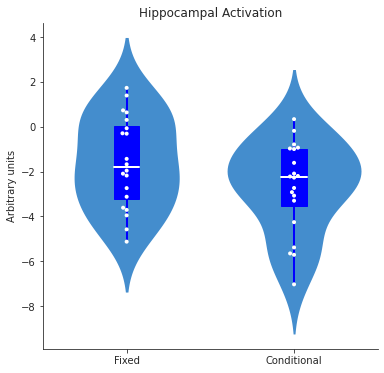

In [34]:
all_fixed = hp_plot_df[['fixed_corr', 'fixed_incorr']].mean(axis=1)
all_fixed = np.array(all_fixed)
all_cond = hp_plot_df[['cond_corr', 'cond_incorr']].mean(axis=1)
all_cond = np.array(all_cond)
print("HPC FIXED Mean / STD / Shapiros: ", np.mean(all_fixed), "/", np.std(all_fixed), "/", stats.shapiro(all_fixed)[0])
print ("HPC COND Mean / STD / Shapiros: ", np.mean(all_cond), "/", np.std(all_cond), "/", stats.shapiro(all_cond)[0])
print("")
print('HPC Fixed vs. Conditional')
if stats.ttest_rel(all_fixed, all_cond)[1] < 0.001:
    print (stats.ttest_rel(all_fixed, all_cond), "**")
elif stats.ttest_rel(all_fixed, all_cond)[1] < 0.0125:
    print (stats.ttest_rel(all_fixed, all_cond), "*")
else:
    print (stats.ttest_rel(all_fixed, all_cond))
cohens_d = ((np.average(all_fixed) - np.average(all_cond)) / (sqrt((np.std(all_fixed, ddof = 1)) 
            ** 2 + np.std(all_cond, ddof = 1) ** 2) / 2))
print ("Cohen's d = ", cohens_d)
N = 2
conditions = ['Fixed', 'Conditional']
allsubjs = [all_fixed, all_cond]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#278fea', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,showcaps=False, 
           boxprops=dict(color='blue', facecolor='blue'),
           whiskerprops=dict(color='blue', linewidth=2, linestyle="-"),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampal Activation")
plt.show()

### Hippocampus - Fixed Correct vs. Fixed Incorrect

HPC Fixed Correct vs. Fixed Incorrect
Ttest_relResult(statistic=2.314914720070809, pvalue=0.031959516936765346)
Cohen's d =  0.5362622522367978


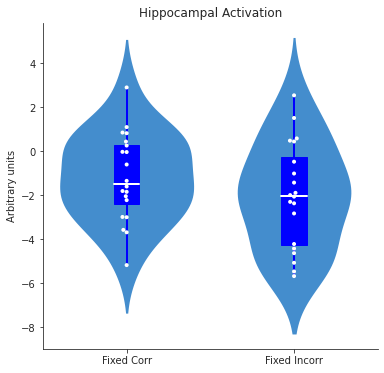

In [35]:
print('HPC Fixed Correct vs. Fixed Incorrect')
if stats.ttest_rel(hp_plot_df['fixed_corr'], hp_plot_df['fixed_incorr'])[1] < 0.001:
    print (stats.ttest_rel(hp_plot_df['fixed_corr'], hp_plot_df['fixed_incorr']), "**")
elif stats.ttest_rel(hp_plot_df['fixed_corr'], hp_plot_df['fixed_incorr'])[1] < 0.0125:
    print (stats.ttest_rel(hp_plot_df['fixed_corr'], hp_plot_df['fixed_incorr']), "*")
else:
    print (stats.ttest_rel(hp_plot_df['fixed_corr'], hp_plot_df['fixed_incorr']))
cohens_d=((np.average(hp_plot_df['fixed_corr'])-np.average(hp_plot_df['fixed_incorr']))
          /(sqrt((np.std(hp_plot_df['fixed_corr'],ddof=1)) 
           **2+np.std(hp_plot_df['fixed_incorr'],ddof = 1)**2)/2))
print("Cohen's d = ", cohens_d)
N = 2
conditions = ['Fixed Corr', 'Fixed Incorr']
allsubjs = [hp_plot_df['fixed_corr'], hp_plot_df['fixed_incorr']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#278fea', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,showcaps=False, 
           boxprops=dict(color='blue', facecolor='blue'),
           whiskerprops=dict(color='blue', linewidth=2, linestyle="-"),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampal Activation")
plt.show()

### Hippocampus - Conditional Correct vs. Conditional Incorrect

HPC Cond Correct vs. Cond Incorrect
Ttest_relResult(statistic=6.055409496769637, pvalue=7.984382993283318e-06) **
Cohen's d =  1.1391544006765189


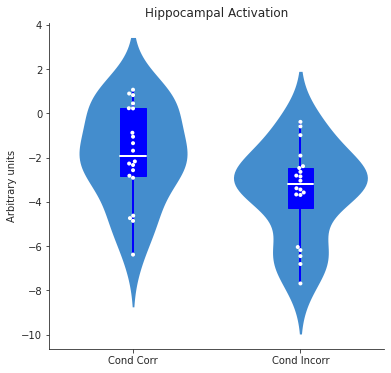

In [36]:
print('HPC Cond Correct vs. Cond Incorrect')
if stats.ttest_rel(hp_plot_df['cond_corr'], hp_plot_df['cond_incorr'])[1] < 0.001:
    print (stats.ttest_rel(hp_plot_df['cond_corr'], hp_plot_df['cond_incorr']), "**")
elif stats.ttest_rel(hp_plot_df['cond_corr'], hp_plot_df['cond_incorr'])[1] < 0.0125:
    print (stats.ttest_rel(hp_plot_df['cond_corr'], hp_plot_df['cond_incorr']), "*")
else:
    print (stats.ttest_rel(hp_plot_df['cond_corr'], hp_plot_df['cond_incorr']))
cohens_d=((np.average(hp_plot_df['cond_corr'])-np.average(hp_plot_df['cond_incorr']))
          /(sqrt((np.std(hp_plot_df['cond_corr'],ddof=1)) 
           **2+np.std(hp_plot_df['cond_incorr'],ddof = 1)**2)/2))
print("Cohen's d = ", cohens_d)
N = 2
conditions = ['Cond Corr', 'Cond Incorr']
allsubjs = [hp_plot_df['cond_corr'], hp_plot_df['cond_incorr']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#278fea', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,showcaps=False, 
           boxprops=dict(color='blue', facecolor='blue'),
           whiskerprops=dict(color='blue', linewidth=2, linestyle="-"),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampal Activation")
plt.show()

# Medial PFC

In [37]:
mpfc_plot_df

,subjid,fixed_corr,fixed_incorr,cond_corr,cond_incorr
WMAZE_001,WMAZE_001,1.174460,4.169234,1.536840,-1.381550
WMAZE_002,WMAZE_002,-3.110868,2.548740,-3.839074,-2.083794
WMAZE_004,WMAZE_004,-0.100851,3.753551,-0.353810,0.912225
WMAZE_005,WMAZE_005,0.333546,2.399473,-1.039531,-1.372778
WMAZE_006,WMAZE_006,-3.797131,-3.066467,-2.550103,-4.521368
WMAZE_007,WMAZE_007,4.116051,6.194452,3.148678,0.308436
WMAZE_008,WMAZE_008,-3.407654,-1.552442,-4.412130,-5.030977
WMAZE_009,WMAZE_009,-4.706687,-5.991596,-5.623633,-2.945036
WMAZE_010,WMAZE_010,-6.255932,-7.361775,-6.511730,-7.332904
WMAZE_012,WMAZE_012,-4.157409,-2.601696,-3.252060,-2.487467


In [38]:
mpfc_anova = {'subjid':[], 'trial':[], 'activation':[]} #reorganizing data for Repeated Measures ANOVA

for i in range(len(subs)):
    for k in ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']: #trial type
        mpfc_anova['subjid'].append(subs[i])
        mpfc_anova['trial'].append(k)
        mpfc_anova['activation'].append(mpfc_plot_df['{0}'.format(k)][i])
df_mpfc_anova = pd.DataFrame(mpfc_anova)

In [39]:
df_mpfc_anova

,subjid,trial,activation
0,WMAZE_001,fixed_corr,1.174460
1,WMAZE_001,fixed_incorr,4.169234
2,WMAZE_001,cond_corr,1.536840
3,WMAZE_001,cond_incorr,-1.381550
4,WMAZE_002,fixed_corr,-3.110868
...,...,...,...
75,WMAZE_026,cond_incorr,-4.340575
76,WMAZE_027,fixed_corr,-1.769686
77,WMAZE_027,fixed_incorr,1.909813
78,WMAZE_027,cond_corr,-3.063144


Descriptives
Mean / STD fixed_corr:  -2.197722484001148 / 2.8736982279426386
Shapiros fixed_corr:  0.43768754601478577

Mean / STD fixed_incorr:  0.23356743957098258 / 4.314610383431733
Shapiros fixed_incorr:  0.888210117816925

Mean / STD cond_corr:  -2.4661366312056336 / 3.017644437655722
Shapiros cond_corr:  0.18295620381832123

Mean / STD cond_incorr:  -2.7584271007359478 / 2.6180472347397736
Shapiros cond_incorr:  0.37213411927223206

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
trial 12.8446 3.0000 57.0000 0.0000



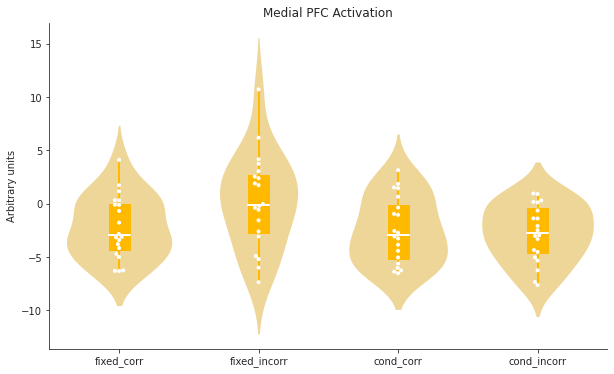

In [40]:
from statsmodels.stats.anova import AnovaRM
print('Descriptives')
for key in ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']:
    print('Mean / STD {0}: '.format(key), np.mean(mpfc_plot['{0}'.format(key)]), "/", np.std(mpfc_plot['{0}'.format(key)]))  
    if stats.shapiro(mpfc_plot['{0}'.format(key)])[1] > 0.049:
        print("Shapiros {0}: ".format(key), stats.shapiro(mpfc_plot['{0}'.format(key)])[1])
    else:
        print("Shapiros {0}: ".format(key), stats.shapiro(mpfc_plot['{0}'.format(key)])[1], "**")
    print("")    
print(AnovaRM(data=df_mpfc_anova, depvar='activation', subject='subjid', within=['trial']).fit()) 
    
N = 4
conditions = ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']
allsubjs = [mpfc_plot['fixed_corr'], mpfc_plot['fixed_incorr'], mpfc_plot['cond_corr'], mpfc_plot['cond_incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(10,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#ffde85', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#ffb900', facecolor='#ffb900'),
           whiskerprops=dict(color='#ffb900', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Medial PFC Activation")
plt.show() 

### Medial PFC - Fixed vs. Conditional

mPFC FIXED Mean / STD / Shapiros:  -0.9820775222150825 / 3.375587725168807 / 0.9699615240097046
mPFC COND Mean / STD / Shapiros:  -2.612281865970791 / 2.72645214324904 / 0.9385942220687866

mPFC Fixed vs. Conditional
Ttest_relResult(statistic=3.979680066215512, pvalue=0.0008025946687640585) **
Cohen's d =  0.7323694275808931


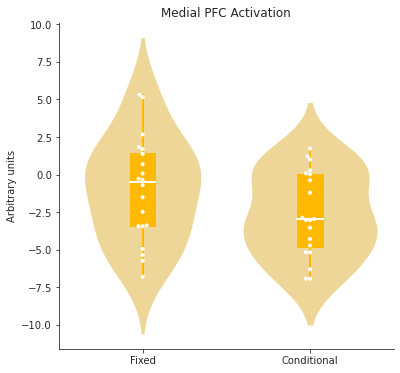

In [41]:
all_fixed = mpfc_plot_df[['fixed_corr', 'fixed_incorr']].mean(axis=1)
all_fixed = np.array(all_fixed)
all_cond = mpfc_plot_df[['cond_corr', 'cond_incorr']].mean(axis=1)
all_cond = np.array(all_cond)
print("mPFC FIXED Mean / STD / Shapiros: ", np.mean(all_fixed), "/", np.std(all_fixed), "/", stats.shapiro(all_fixed)[0])
print ("mPFC COND Mean / STD / Shapiros: ", np.mean(all_cond), "/", np.std(all_cond), "/", stats.shapiro(all_cond)[0])
print("")
print('mPFC Fixed vs. Conditional')
if stats.ttest_rel(all_fixed, all_cond)[1] < 0.001:
    print (stats.ttest_rel(all_fixed, all_cond), "**")
elif stats.ttest_rel(all_fixed, all_cond)[1] < 0.0125:
    print (stats.ttest_rel(all_fixed, all_cond), "*")
else:
    print (stats.ttest_rel(all_fixed, all_cond))
cohens_d = ((np.average(all_fixed) - np.average(all_cond)) / (sqrt((np.std(all_fixed, ddof = 1)) 
            ** 2 + np.std(all_cond, ddof = 1) ** 2) / 2))
print ("Cohen's d = ", cohens_d)
N = 2
conditions = ['Fixed', 'Conditional']
allsubjs = [all_fixed, all_cond]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#ffde85', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#ffb900', facecolor='#ffb900'),
           whiskerprops=dict(color='#ffb900', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Medial PFC Activation")
plt.show()

### Medial PFC - Fixed Correct vs. Fixed Incorrect

mPFC Fixed Correct vs. Fixed Incorrect
Ttest_relResult(statistic=-3.707764388076384, pvalue=0.0014930808839113915) *
Cohen's d =  -0.9142445026096385


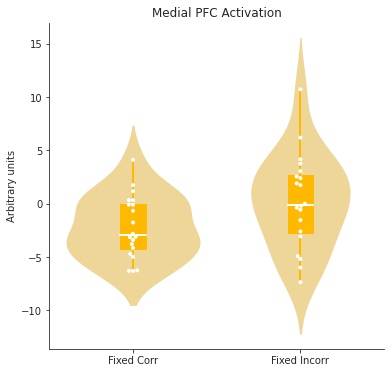

In [42]:
print('mPFC Fixed Correct vs. Fixed Incorrect')
if stats.ttest_rel(mpfc_plot_df['fixed_corr'], mpfc_plot_df['fixed_incorr'])[1] < 0.001:
    print (stats.ttest_rel(mpfc_plot_df['fixed_corr'], mpfc_plot_df['fixed_incorr']), "**")
elif stats.ttest_rel(mpfc_plot_df['fixed_corr'], mpfc_plot_df['fixed_incorr'])[1] < 0.0125:
    print (stats.ttest_rel(mpfc_plot_df['fixed_corr'], mpfc_plot_df['fixed_incorr']), "*")
else:
    print (stats.ttest_rel(mpfc_plot_df['fixed_corr'], mpfc_plot_df['fixed_incorr']))
cohens_d=((np.average(mpfc_plot_df['fixed_corr'])-np.average(mpfc_plot_df['fixed_incorr']))
          /(sqrt((np.std(mpfc_plot_df['fixed_corr'],ddof=1)) 
           **2+np.std(mpfc_plot_df['fixed_incorr'],ddof = 1)**2)/2))
print("Cohen's d = ", cohens_d)
N = 2
conditions = ['Fixed Corr', 'Fixed Incorr']
allsubjs = [mpfc_plot_df['fixed_corr'], mpfc_plot_df['fixed_incorr']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#ffde85', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#ffb900', facecolor='#ffb900'),
           whiskerprops=dict(color='#ffb900', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Medial PFC Activation")
plt.show()

### Medial PFC - Conditional Correct vs. Conditional Incorrect

mPFC Cond Correct vs. Cond Incorrect
Ttest_relResult(statistic=0.8616152919297827, pvalue=0.39964309889047633)
Cohen's d =  0.14262158468115893


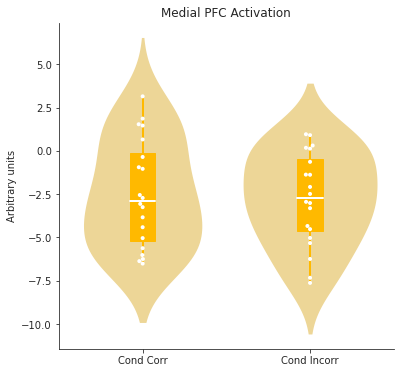

In [43]:
print('mPFC Cond Correct vs. Cond Incorrect')
if stats.ttest_rel(mpfc_plot_df['cond_corr'], mpfc_plot_df['cond_incorr'])[1] < 0.001:
    print (stats.ttest_rel(mpfc_plot_df['cond_corr'], mpfc_plot_df['cond_incorr']), "**")
elif stats.ttest_rel(mpfc_plot_df['cond_corr'], mpfc_plot_df['cond_incorr'])[1] < 0.0125:
    print (stats.ttest_rel(mpfc_plot_df['cond_corr'], mpfc_plot_df['cond_incorr']), "*")
else:
    print (stats.ttest_rel(mpfc_plot_df['cond_corr'], mpfc_plot_df['cond_incorr']))
cohens_d=((np.average(mpfc_plot_df['cond_corr'])-np.average(mpfc_plot_df['cond_incorr']))
          /(sqrt((np.std(mpfc_plot_df['cond_corr'],ddof=1)) 
           **2+np.std(mpfc_plot_df['cond_incorr'],ddof = 1)**2)/2))
print("Cohen's d = ", cohens_d)
N = 2
conditions = ['Cond Corr', 'Cond Incorr']
allsubjs = [mpfc_plot_df['cond_corr'], mpfc_plot_df['cond_incorr']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#ffde85', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#ffb900', facecolor='#ffb900'),
           whiskerprops=dict(color='#ffb900', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Medial PFC Activation")
plt.show()

# Caudate

In [44]:
caud_plot_df

,subjid,fixed_corr,fixed_incorr,cond_corr,cond_incorr
WMAZE_001,WMAZE_001,4.787468,1.473787,7.664730,4.908491
WMAZE_002,WMAZE_002,-0.700732,-0.952384,-1.769951,0.517127
WMAZE_004,WMAZE_004,-1.128481,3.166237,-1.848093,-1.182379
WMAZE_005,WMAZE_005,2.002747,1.901171,2.665573,1.164143
WMAZE_006,WMAZE_006,-3.335205,-4.133302,-2.277277,-0.705186
WMAZE_007,WMAZE_007,5.550164,4.708094,8.251088,5.394964
WMAZE_008,WMAZE_008,-1.403055,-1.699169,-2.298193,-0.471250
WMAZE_009,WMAZE_009,-1.029400,-3.870051,-1.068510,-1.420948
WMAZE_010,WMAZE_010,-1.937441,-1.393283,1.233093,-1.541179
WMAZE_012,WMAZE_012,0.995845,0.799400,0.396604,0.102704


In [45]:
caud_anova = {'subjid':[], 'trial':[], 'activation':[]} #reorganizing data for Repeated Measures ANOVA

for i in range(len(subs)):
    for k in ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']: #trial type
        caud_anova['subjid'].append(subs[i])
        caud_anova['trial'].append(k)
        caud_anova['activation'].append(caud_plot_df['{0}'.format(k)][i])
df_caud_anova = pd.DataFrame(caud_anova)

In [46]:
df_caud_anova

,subjid,trial,activation
0,WMAZE_001,fixed_corr,4.787468
1,WMAZE_001,fixed_incorr,1.473787
2,WMAZE_001,cond_corr,7.664730
3,WMAZE_001,cond_incorr,4.908491
4,WMAZE_002,fixed_corr,-0.700732
...,...,...,...
75,WMAZE_026,cond_incorr,3.503884
76,WMAZE_027,fixed_corr,-1.274505
77,WMAZE_027,fixed_incorr,1.748968
78,WMAZE_027,cond_corr,-1.115687


Descriptives
Mean / STD fixed_corr:  0.1250688371133711 / 2.1349169678696187
Shapiros fixed_corr:  0.058594729751348495

Mean / STD fixed_incorr:  0.47824482270462704 / 3.24636716081997
Shapiros fixed_incorr:  0.14369210600852966

Mean / STD cond_corr:  1.3762459235305218 / 2.9193975547539117
Shapiros cond_corr:  0.08338283002376556

Mean / STD cond_incorr:  0.6903510181575954 / 2.1309587104113668
Shapiros cond_incorr:  0.21728640794754028

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
trial  1.6372 3.0000 57.0000 0.1909



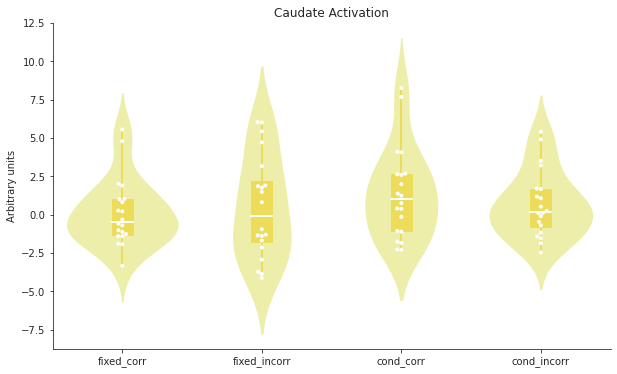

In [47]:
from statsmodels.stats.anova import AnovaRM
print('Descriptives')
for key in ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']:
    print('Mean / STD {0}: '.format(key), np.mean(caud_plot['{0}'.format(key)]), "/", np.std(caud_plot['{0}'.format(key)]))  
    if stats.shapiro(caud_plot['{0}'.format(key)])[1] > 0.049:
        print("Shapiros {0}: ".format(key), stats.shapiro(caud_plot['{0}'.format(key)])[1])
    else:
        print("Shapiros {0}: ".format(key), stats.shapiro(caud_plot['{0}'.format(key)])[1], "**")
    print("")    
print(AnovaRM(data=df_caud_anova, depvar='activation', subject='subjid', within=['trial']).fit()) 
    
N = 4
conditions = ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']
allsubjs = [caud_plot['fixed_corr'], caud_plot['fixed_incorr'], caud_plot['cond_corr'], caud_plot['cond_incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(10,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#fcfc9d', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#eddc5a', facecolor='#eddc5a'),
           whiskerprops=dict(color='#eddc5a', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate Activation")
plt.show() 

### Caudate - Fixed vs. Conditional

Caudate FIXED Mean / STD / Shapiros:  0.3016568299089991 / 2.3230509348992596 / 0.9692208170890808
Caudate COND Mean / STD / Shapiros:  1.0332984708440587 / 2.3955337372926957 / 0.876815676689148

Caudate Fixed vs. Conditional
Ttest_relResult(statistic=-1.6412810294747116, pvalue=0.11718865211741727)
Cohen's d =  -0.42740758554855035


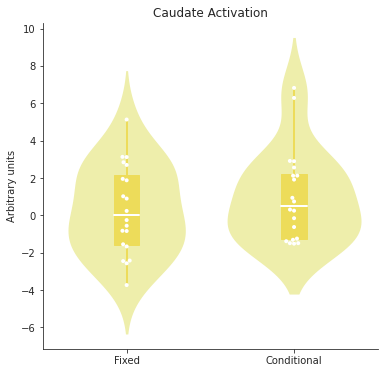

In [48]:
all_fixed = caud_plot_df[['fixed_corr', 'fixed_incorr']].mean(axis=1)
all_fixed = np.array(all_fixed)
all_cond = caud_plot_df[['cond_corr', 'cond_incorr']].mean(axis=1)
all_cond = np.array(all_cond)
print("Caudate FIXED Mean / STD / Shapiros: ", np.mean(all_fixed), "/", np.std(all_fixed), "/", stats.shapiro(all_fixed)[0])
print ("Caudate COND Mean / STD / Shapiros: ", np.mean(all_cond), "/", np.std(all_cond), "/", stats.shapiro(all_cond)[0])
print("")
print('Caudate Fixed vs. Conditional')
if stats.ttest_rel(all_fixed, all_cond)[1] < 0.001:
    print (stats.ttest_rel(all_fixed, all_cond), "**")
elif stats.ttest_rel(all_fixed, all_cond)[1] < 0.0125:
    print (stats.ttest_rel(all_fixed, all_cond), "*")
else:
    print (stats.ttest_rel(all_fixed, all_cond))
cohens_d = ((np.average(all_fixed) - np.average(all_cond)) / (sqrt((np.std(all_fixed, ddof = 1)) 
            ** 2 + np.std(all_cond, ddof = 1) ** 2) / 2))
print ("Cohen's d = ", cohens_d)
N = 2
conditions = ['Fixed', 'Conditional']
allsubjs = [all_fixed, all_cond]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#fcfc9d', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#eddc5a', facecolor='#eddc5a'),
           whiskerprops=dict(color='#eddc5a', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate Activation")
plt.show()

### Caudate - Fixed Correct vs. Fixed Incorrect

Caudate Fixed Correct vs. Fixed Incorrect
Ttest_relResult(statistic=-0.5247289865665815, pvalue=0.6058406174453306)
Cohen's d =  -0.17719070736411127


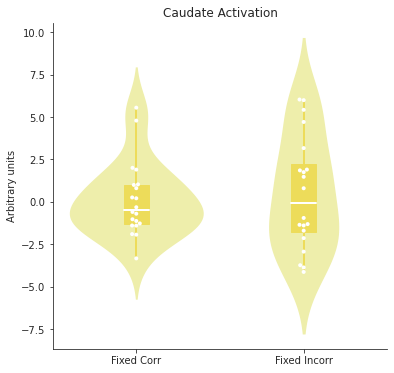

In [49]:
print('Caudate Fixed Correct vs. Fixed Incorrect')
if stats.ttest_rel(caud_plot_df['fixed_corr'], caud_plot_df['fixed_incorr'])[1] < 0.001:
    print (stats.ttest_rel(caud_plot_df['fixed_corr'], caud_plot_df['fixed_incorr']), "**")
elif stats.ttest_rel(caud_plot_df['fixed_corr'], caud_plot_df['fixed_incorr'])[1] < 0.0125:
    print (stats.ttest_rel(caud_plot_df['fixed_corr'], caud_plot_df['fixed_incorr']), "*")
else:
    print (stats.ttest_rel(caud_plot_df['fixed_corr'], caud_plot_df['fixed_incorr']))
cohens_d=((np.average(caud_plot_df['fixed_corr'])-np.average(caud_plot_df['fixed_incorr']))
          /(sqrt((np.std(caud_plot_df['fixed_corr'],ddof=1)) 
           **2+np.std(caud_plot_df['fixed_incorr'],ddof = 1)**2)/2))
print("Cohen's d = ", cohens_d)
N = 2
conditions = ['Fixed Corr', 'Fixed Incorr']
allsubjs = [caud_plot_df['fixed_corr'], caud_plot_df['fixed_incorr']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#fcfc9d', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#eddc5a', facecolor='#eddc5a'),
           whiskerprops=dict(color='#eddc5a', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate Activation")
plt.show()

### Caudate - Conditional Correct vs. Conditional Incorrect

Caudate Cond Correct vs. Cond Incorrect
Ttest_relResult(statistic=1.6783074113228102, pvalue=0.10965957014531309)
Cohen's d =  0.3699248432178087


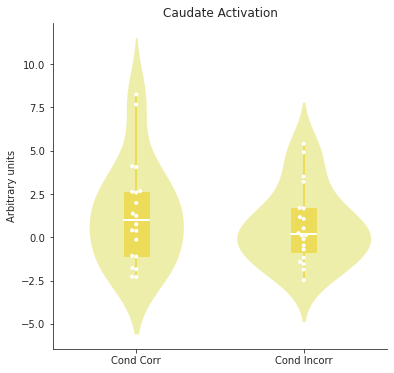

In [50]:
print('Caudate Cond Correct vs. Cond Incorrect')
if stats.ttest_rel(caud_plot_df['cond_corr'], caud_plot_df['cond_incorr'])[1] < 0.001:
    print (stats.ttest_rel(caud_plot_df['cond_corr'], caud_plot_df['cond_incorr']), "**")
elif stats.ttest_rel(caud_plot_df['cond_corr'], caud_plot_df['cond_incorr'])[1] < 0.0125:
    print (stats.ttest_rel(caud_plot_df['cond_corr'], caud_plot_df['cond_incorr']), "*")
else:
    print (stats.ttest_rel(caud_plot_df['cond_corr'], caud_plot_df['cond_incorr']))
cohens_d=((np.average(caud_plot_df['cond_corr'])-np.average(caud_plot_df['cond_incorr']))
          /(sqrt((np.std(caud_plot_df['cond_corr'],ddof=1)) 
           **2+np.std(caud_plot_df['cond_incorr'],ddof = 1)**2)/2))
print("Cohen's d = ", cohens_d)
N = 2
conditions = ['Cond Corr', 'Cond Incorr']
allsubjs = [caud_plot_df['cond_corr'], caud_plot_df['cond_incorr']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#fcfc9d', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#eddc5a', facecolor='#eddc5a'),
           whiskerprops=dict(color='#eddc5a', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate Activation")
plt.show()

# Putamen

In [51]:
put_plot_df

,subjid,fixed_corr,fixed_incorr,cond_corr,cond_incorr
WMAZE_001,WMAZE_001,5.271834,1.796487,7.339155,3.870579
WMAZE_002,WMAZE_002,-1.250251,-2.403613,-1.905791,-3.051393
WMAZE_004,WMAZE_004,3.854627,1.495607,1.794667,0.981609
WMAZE_005,WMAZE_005,-0.740927,-1.612107,-0.806878,-3.662258
WMAZE_006,WMAZE_006,-1.252141,-1.767737,-1.305319,-1.609243
WMAZE_007,WMAZE_007,6.615127,3.573429,6.792525,3.843243
WMAZE_008,WMAZE_008,-1.324859,-3.071950,-2.083925,-1.817884
WMAZE_009,WMAZE_009,-0.540603,-4.289435,-2.086220,-3.620748
WMAZE_010,WMAZE_010,-0.026844,-0.579023,-1.090601,-3.614487
WMAZE_012,WMAZE_012,1.072378,0.539848,1.034425,1.031574


In [52]:
put_anova = {'subjid':[], 'trial':[], 'activation':[]} #reorganizing data for Repeated Measures ANOVA

for i in range(len(subs)):
    for k in ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']: #trial type
        put_anova['subjid'].append(subs[i])
        put_anova['trial'].append(k)
        put_anova['activation'].append(put_plot_df['{0}'.format(k)][i])
df_put_anova = pd.DataFrame(put_anova)

In [53]:
df_put_anova

,subjid,trial,activation
0,WMAZE_001,fixed_corr,5.271834
1,WMAZE_001,fixed_incorr,1.796487
2,WMAZE_001,cond_corr,7.339155
3,WMAZE_001,cond_incorr,3.870579
4,WMAZE_002,fixed_corr,-1.250251
...,...,...,...
75,WMAZE_026,cond_incorr,-2.506402
76,WMAZE_027,fixed_corr,1.660773
77,WMAZE_027,fixed_incorr,-0.334982
78,WMAZE_027,cond_corr,0.595287


Descriptives
Mean / STD fixed_corr:  1.0583252130519447 / 2.297602916932908
Shapiros fixed_corr:  0.01950855739414692 **

Mean / STD fixed_incorr:  -0.5767189212665473 / 2.6785970872423435
Shapiros fixed_incorr:  0.11224791407585144

Mean / STD cond_corr:  0.9913057983198812 / 2.6456572610138824
Shapiros cond_corr:  0.036627147346735 **

Mean / STD cond_incorr:  -1.1744934460366991 / 2.2159369941686546
Shapiros cond_incorr:  0.020514775067567825 **

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
trial 13.6646 3.0000 57.0000 0.0000



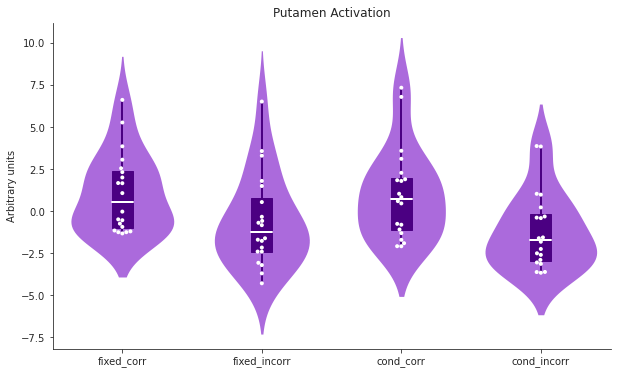

In [54]:
from statsmodels.stats.anova import AnovaRM
print('Descriptives')
for key in ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']:
    print('Mean / STD {0}: '.format(key), np.mean(put_plot['{0}'.format(key)]), "/", np.std(put_plot['{0}'.format(key)]))  
    if stats.shapiro(put_plot['{0}'.format(key)])[1] > 0.049:
        print("Shapiros {0}: ".format(key), stats.shapiro(put_plot['{0}'.format(key)])[1])
    else:
        print("Shapiros {0}: ".format(key), stats.shapiro(put_plot['{0}'.format(key)])[1], "**")
    print("")    
print(AnovaRM(data=df_put_anova, depvar='activation', subject='subjid', within=['trial']).fit()) 
    
N = 4
conditions = ['fixed_corr', 'fixed_incorr', 'cond_corr', 'cond_incorr']
allsubjs = [put_plot['fixed_corr'], put_plot['fixed_incorr'], put_plot['cond_corr'], put_plot['cond_incorr']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(10,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#af52f4', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='indigo', facecolor='indigo'),
           whiskerprops=dict(color='indigo', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Putamen Activation")
plt.show() 

### Putamen - Fixed vs. Conditional

Putamen FIXED Mean / STD / Shapiros:  0.24080314589269877 / 2.266373947242914 / 0.8964106440544128
Putamen COND Mean / STD / Shapiros:  -0.09159382385840908 / 2.336930719446225 / 0.8738170266151428

Putamen Fixed vs. Conditional
Ttest_relResult(statistic=0.9986456664182536, pvalue=0.33051577610782157)
Cohen's d =  0.19904126556581725


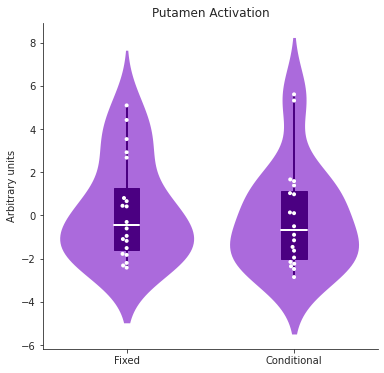

In [55]:
all_fixed = put_plot_df[['fixed_corr', 'fixed_incorr']].mean(axis=1)
all_fixed = np.array(all_fixed)
all_cond = put_plot_df[['cond_corr', 'cond_incorr']].mean(axis=1)
all_cond = np.array(all_cond)
print("Putamen FIXED Mean / STD / Shapiros: ", np.mean(all_fixed), "/", np.std(all_fixed), "/", stats.shapiro(all_fixed)[0])
print ("Putamen COND Mean / STD / Shapiros: ", np.mean(all_cond), "/", np.std(all_cond), "/", stats.shapiro(all_cond)[0])
print("")
print('Putamen Fixed vs. Conditional')
if stats.ttest_rel(all_fixed, all_cond)[1] < 0.001:
    print (stats.ttest_rel(all_fixed, all_cond), "**")
elif stats.ttest_rel(all_fixed, all_cond)[1] < 0.0125:
    print (stats.ttest_rel(all_fixed, all_cond), "*")
else:
    print (stats.ttest_rel(all_fixed, all_cond))
cohens_d = ((np.average(all_fixed) - np.average(all_cond)) / (sqrt((np.std(all_fixed, ddof = 1)) 
            ** 2 + np.std(all_cond, ddof = 1) ** 2) / 2))
print ("Cohen's d = ", cohens_d)
N = 2
conditions = ['Fixed', 'Conditional']
allsubjs = [all_fixed, all_cond]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#af52f4', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='indigo', facecolor='indigo'),
           whiskerprops=dict(color='indigo', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Putamen Activation")
plt.show()

### Caudate - Fixed Correct vs. Fixed Incorrect

Putamen Fixed Correct vs. Fixed Incorrect
Ttest_relResult(statistic=3.4124590937758046, pvalue=0.0029209624067932) *
Cohen's d =  0.903169498044612


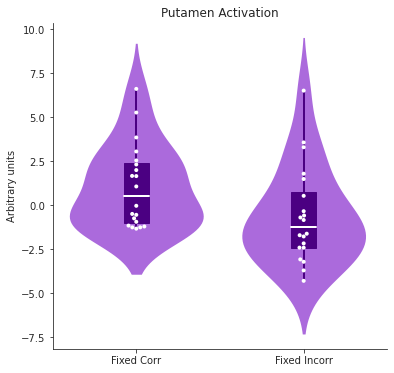

In [56]:
print('Putamen Fixed Correct vs. Fixed Incorrect')
if stats.ttest_rel(put_plot_df['fixed_corr'], put_plot_df['fixed_incorr'])[1] < 0.001:
    print (stats.ttest_rel(put_plot_df['fixed_corr'], put_plot_df['fixed_incorr']), "**")
elif stats.ttest_rel(put_plot_df['fixed_corr'], put_plot_df['fixed_incorr'])[1] < 0.0125:
    print (stats.ttest_rel(put_plot_df['fixed_corr'], put_plot_df['fixed_incorr']), "*")
else:
    print (stats.ttest_rel(put_plot_df['fixed_corr'], put_plot_df['fixed_incorr']))
cohens_d=((np.average(put_plot_df['fixed_corr'])-np.average(put_plot_df['fixed_incorr']))
          /(sqrt((np.std(put_plot_df['fixed_corr'],ddof=1)) 
           **2+np.std(put_plot_df['fixed_incorr'],ddof = 1)**2)/2))
print("Cohen's d = ", cohens_d)
N = 2
conditions = ['Fixed Corr', 'Fixed Incorr']
allsubjs = [put_plot_df['fixed_corr'], put_plot_df['fixed_incorr']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#af52f4', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='indigo', facecolor='indigo'),
           whiskerprops=dict(color='indigo', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Putamen Activation")
plt.show()

### Caudate - Conditional Correct vs. Conditional Incorrect

Putamen Cond Correct vs. Cond Incorrect
Ttest_relResult(statistic=6.7179368577959915, pvalue=2.0222645392266706e-06) **
Cohen's d =  1.2233657557489734


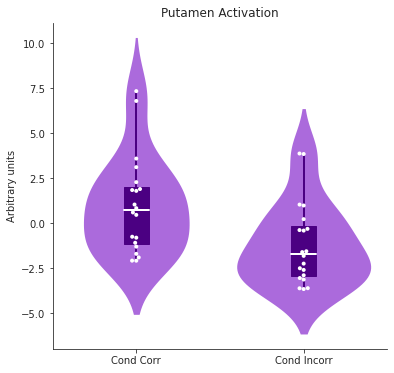

In [57]:
print('Putamen Cond Correct vs. Cond Incorrect')
if stats.ttest_rel(put_plot_df['cond_corr'], put_plot_df['cond_incorr'])[1] < 0.001:
    print (stats.ttest_rel(put_plot_df['cond_corr'], put_plot_df['cond_incorr']), "**")
elif stats.ttest_rel(put_plot_df['cond_corr'], put_plot_df['cond_incorr'])[1] < 0.0125:
    print (stats.ttest_rel(put_plot_df['cond_corr'], put_plot_df['cond_incorr']), "*")
else:
    print (stats.ttest_rel(put_plot_df['cond_corr'], put_plot_df['cond_incorr']))
cohens_d=((np.average(put_plot_df['cond_corr'])-np.average(put_plot_df['cond_incorr']))
          /(sqrt((np.std(put_plot_df['cond_corr'],ddof=1)) 
           **2+np.std(put_plot_df['cond_incorr'],ddof = 1)**2)/2))
print("Cohen's d = ", cohens_d)
N = 2
conditions = ['Cond Corr', 'Cond Incorr']
allsubjs = [put_plot_df['cond_corr'], put_plot_df['cond_incorr']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#af52f4', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis=[0,100], positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='indigo', facecolor='indigo'),
           whiskerprops=dict(color='indigo', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Arbitrary units")
ax.set_title("Putamen Activation")
plt.show()